# SETUP dan IMPORT LIBRARIES

In [ ]:
!pip install scikeras

In [ ]:
!pip install --upgrade scikeras
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 102.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
# ============================
# SETUP & IMPORT LIBRARIES
# ============================

# General utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import random

# Preprocessing & Evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Deep Learning (Bi-LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# XGBoost for residual modeling
import xgboost as xgb
from xgboost import XGBRegressor
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Data Cleaning

In [ ]:
# 1) Baca CSV
df = pd.read_csv("dataimbalhasilcsv.csv")




FileNotFoundError: [Errno 2] No such file or directory: 'dataimbalhasilcsv.csv'

In [ ]:
# === GANTI sesuai kolom kamu ===
date1, val1 = "Date1", "10year"
date2, val2 = "Date2", "5year"
date3, val3 = "Date3", "1year"


In [ ]:
# ===============================

# 2) Ambil masing-masing seri
s1 = df[[date1, val1]].rename(columns={date1: "Date", val1: "var1"}).copy()
s2 = df[[date2, val2]].rename(columns={date2: "Date", val2: "var2"}).copy()
s3 = df[[date3, val3]].rename(columns={date3: "Date", val3: "var3"}).copy()



In [ ]:
# 3) Parse tanggal (web format mm/dd/yyyy) + bersihin
def clean_series(s):
    s["Date"] = pd.to_datetime(s["Date"], format="%d/%m/%Y", errors="coerce")
    s = s.dropna(subset=["Date"])                # buang baris date invalid/kosong
    s = s.drop_duplicates("Date", keep="last")   # kalau ada dobel tanggal
    return s

s1, s2, s3 = map(clean_series, (s1, s2, s3))



In [ ]:
# 4) INNER JOIN = IRISAN tanggal
merged = (
    s1.merge(s2, on="Date", how="inner")
      .merge(s3, on="Date", how="inner")
      .sort_values("Date")
      .reset_index(drop=True)
)

print("Jumlah tanggal irisan:", len(merged))
print(merged.head())

# 5) Save
merged.to_csv("intersection_3vars.csv", index=False)

Jumlah tanggal irisan: 2988
        Date  var1  var2  var3
0 2014-01-02  8.46  8.02  7.42
1 2014-01-03  8.55  8.38  7.56
2 2014-01-06  9.10  8.45  7.52
3 2014-01-07  9.12  8.55  7.56
4 2014-01-08  9.04  8.45  7.57


#Statistik Deskriptif

In [ ]:
# baca csv
df = pd.read_csv("cleandataimbalhasilcsv.csv")

Statistik Pemusatan

In [ ]:
pemusatan = pd.DataFrame({
    "mean": df.mean(numeric_only=True),
    "median": df.median(numeric_only=True),
    "mode": df.mode(numeric_only=True).iloc[0]
})

print([pemusatan])


[            mean  median  mode
10year  7.201988    7.04  7.07
5year   6.770211    6.70  6.51
1year   5.960699    6.26  6.26]


Statistik Penyebaran

In [ ]:
penyebaran = pd.DataFrame({
    "Variance": df.var(numeric_only=True),
    "Std Dev": df.std(numeric_only=True),
    "Min": df.min(numeric_only=True),
    "Max": df.max(numeric_only=True),
    "Range": df.max(numeric_only=True) - df.min(numeric_only=True),
    "IQR": df.quantile(0.75, numeric_only=True) - df.quantile(0.25, numeric_only=True)
})

print("\nStatistik Penyebaran")
print(penyebaran)



Statistik Penyebaran
        Variance   Std Dev   Min   Max  Range     IQR
10year  0.536645  0.732561  5.91  9.77   3.86  1.1500
5year   0.857429  0.925974  5.02  9.66   4.64  1.3625
1year   1.509202  1.228496  2.85  8.89   6.04  1.5300


#Deteksi Missing Value

In [ ]:
# cek jumlah missing per kolom
missing_count = df.isna().sum()

print("Jumlah Missing Value per Kolom")
print(missing_count)


Jumlah Missing Value per Kolom
Date      0
10year    0
5year     0
1year     0
dtype: int64


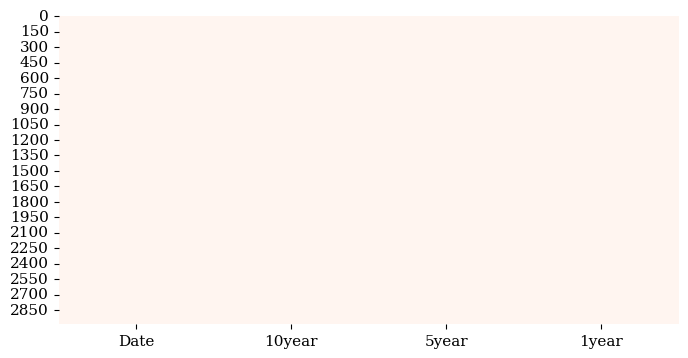

In [ ]:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 11
})

plt.figure(figsize=(8,4))
sns.heatmap(df.isna(), cbar=False, cmap=sns.color_palette("Reds", as_cmap=True))
plt.show()


# Normalisasi

Min-Max Scaling

In [ ]:
cols = ["10year", "5year", "1year"]

before = df[["Date"] + cols].copy()


In [ ]:
scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[cols] = scaler.fit_transform(df[cols])


In [ ]:
after = df_scaled[["Date"] + cols].copy()


In [ ]:
print("=== DATA SEBELUM MIN-MAX SCALING (HEAD 5) ===")
print(before.head())

print("\n=== DATA SEBELUM MIN-MAX SCALING (TAIL 5) ===")
print(before.tail())


print("\n=== DATA SETELAH MIN-MAX SCALING (HEAD 5) ===")
print(after.head())

print("\n=== DATA SETELAH MIN-MAX SCALING (TAIL 5) ===")
print(after.tail())


=== DATA SEBELUM MIN-MAX SCALING (HEAD 5) ===
         Date  10year  5year  1year
0  02/01/2014    8.46   8.02   7.42
1  03/01/2014    8.55   8.38   7.56
2  06/01/2014    9.10   8.45   7.52
3  07/01/2014    9.12   8.55   7.56
4  08/01/2014    9.04   8.45   7.57

=== DATA SEBELUM MIN-MAX SCALING (TAIL 5) ===
            Date  10year  5year  1year
2983  23/12/2025    6.14   5.62    5.0
2984  24/12/2025    6.12   5.62    5.0
2985  29/12/2025    6.12   5.62    5.0
2986  30/12/2025    6.12   5.61    5.0
2987  31/12/2025    6.12   5.54    5.0

=== DATA SETELAH MIN-MAX SCALING (HEAD 5) ===
         Date    10year     5year     1year
0  02/01/2014  0.660622  0.646552  0.756623
1  03/01/2014  0.683938  0.724138  0.779801
2  06/01/2014  0.826425  0.739224  0.773179
3  07/01/2014  0.831606  0.760776  0.779801
4  08/01/2014  0.810881  0.739224  0.781457

=== DATA SETELAH MIN-MAX SCALING (TAIL 5) ===
            Date    10year     5year    1year
2983  23/12/2025  0.059585  0.129310  0.35596
2984  2

# Pembentukkan Model Bi-LSTM

In [ ]:
import pandas as pd

# ============================
# IMPORT DATASET (TIME SERIES)
# ============================

file_path = "/content/cleandataimbalhasilcsv.csv"  # ubah sesuai file kamu
df = pd.read_csv(file_path)

# Deteksi otomatis kolom tanggal
date_column = None
for col in df.columns:
    if "date" in col.lower() or "time" in col.lower() or "tanggal" in col.lower():
        date_column = col
        break

if date_column is None:
    raise ValueError("Tidak ditemukan kolom tanggal! Tolong beri tahu nama kolom datetime.")

# --- Parse tanggal: sekarang format dd/mm/yyyy ---
df[date_column] = pd.to_datetime(
    df[date_column].astype(str).str.strip(),
    dayfirst=True,       # <-- kunci untuk dd/mm/yyyy
    errors="coerce"      # <-- yang gagal jadi NaT (biar tidak crash)
)

# Kalau ada yang gagal parse, kasih info & buang barisnya (opsional tapi recommended)
bad_dates = df[date_column].isna().sum()
if bad_dates > 0:
    print(f"WARNING: {bad_dates} baris tanggal gagal diparse (jadi NaT). Baris tsb akan di-drop.")
    df = df.dropna(subset=[date_column])

# Urutkan berdasarkan waktu
df = df.sort_values(by=date_column)

# Set kolom tanggal sebagai index
df = df.set_index(date_column)

print("Preview data:")
display(df.head())

print("\nMissing values per column:")
print(df.isnull().sum())


Preview data:


,10year,5year,1year
Date,,,
2014-01-02,8.46,8.02,7.42
2014-01-03,8.55,8.38,7.56
2014-01-06,9.10,8.45,7.52
2014-01-07,9.12,8.55,7.56
2014-01-08,9.04,8.45,7.57



Missing values per column:
10year    0
5year     0
1year     0
dtype: int64


In [ ]:
# ============================
# DEFINISI FUNGSI YANG DIPERLUKAN
# ============================

def mae(y_true, y_pred):
    """Mean Absolute Error"""
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    """Mean Squared Error"""
    return np.mean((y_true - y_pred) ** 2)

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100  # +eps untuk hindari pembagian 0

def evaluate_all(y_true, y_pred):
    """Mengembalikan semua hasil evaluasi sekaligus"""
    return {
        "MAE" : mae(y_true, y_pred),
        "MSE" : mse(y_true, y_pred),
        "RMSE": np.sqrt(mse(y_true, y_pred)),
        "MAPE": mape(y_true, y_pred)
    }


In [ ]:
def create_sequences_multivar_to_univar(data, target_col, seq_len):
    """
    data       : array 2D (T, num_features)
    target_col : index kolom target (int)
    seq_len    : panjang window

    Output:
      X shape = (samples, seq_len, num_features)
      y shape = (samples, 1)  --> univariate output
    """
    data = np.array(data)
    if data.ndim == 1:
        data = data.reshape(-1, 1)

    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :])               # semua fitur (3 input)
        y.append(data[i+seq_len, target_col])        # hanya target (1 output)

    return np.array(X), np.array(y).reshape(-1, 1)


In [ ]:
# ============================
# 1) SETTINGS
# ============================
feature_columns = ["1year"]                     # 1 input
target_name = "1year"                           # 1 output
SEQ_LEN = 30
train_ratio = 0.9

In [ ]:
# ============================
# 2) SPLIT RAW + SCALING (NO LEAKAGE)
# ============================
for col in feature_columns:
    if col not in df.columns:
        raise ValueError(f"Kolom '{col}' tidak ditemukan pada dataset!")

values = df[feature_columns].values  # (T,3)
T = len(values)
split_idx = int(T * train_ratio)

train_raw = values[:split_idx]
test_raw  = values[split_idx:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_raw)
test_scaled  = scaler.transform(test_raw)

print("✅ Scaling selesai (fit di train saja).")

✅ Scaling selesai (fit di train saja).


In [ ]:
# ============================
# 3) WINDOWING (3 input -> 1 output)
# ============================
target_col = feature_columns.index(target_name)

X_train, y_train = create_sequences_multivar_to_univar(train_scaled, target_col, SEQ_LEN)

test_with_context = np.vstack([train_scaled[-SEQ_LEN:], test_scaled])
X_test, y_test = create_sequences_multivar_to_univar(test_with_context, target_col, SEQ_LEN)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)

X_train: (2659, 30, 1) y_train: (2659, 1)
X_test : (299, 30, 1) y_test : (299, 1)


In [ ]:
# ============================
# 4) MODEL BUILDER (SciKeras)
# ============================
def build_bilstm_model(units=32, dropout=0.2, optimizer="adam", seq_len=24, num_features=3):
    model = Sequential([
        Bidirectional(LSTM(units, return_sequences=False), input_shape=(seq_len, num_features)),
        Dropout(dropout),
        Dense(1)  # univariate output
    ])
    model.compile(loss="mse", optimizer=optimizer)
    return model

bilstm_reg = KerasRegressor(
    model=build_bilstm_model,
    verbose=0,
    model__seq_len=X_train.shape[1],
    model__num_features=X_train.shape[2],
)

param_grid = {
    "model__units": [24,36,48],
    "model__dropout": [0.1,0.2],
    "model__optimizer": ["adam"],
    "batch_size": [36,48,60],
    "epochs": [50,100]
}

tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(
    estimator=bilstm_reg,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    return_train_score=True
)

print("⏳ Running GridSearchCV...")
grid_result = grid.fit(X_train, y_train)

print("\n===== BEST GRIDSEARCH RESULT =====")
print("Best MSE (CV):", -grid_result.best_score_)
print("Best Params  :", grid_result.best_params_)

⏳ Running GridSearchCV...

===== BEST GRIDSEARCH RESULT =====
Best MSE (CV): 0.0004447789350416587
Best Params  : {'batch_size': 48, 'epochs': 100, 'model__dropout': 0.1, 'model__optimizer': 'adam', 'model__units': 48}


In [ ]:
# ============================
# 5) TABLE PERBANDINGAN KOMBINASI (Bab 4)
# ============================
results_df = pd.DataFrame(grid_result.cv_results_)
results_df["mean_test_MSE"]  = -results_df["mean_test_score"]
results_df["mean_train_MSE"] = -results_df["mean_train_score"]

show_cols = [
    "mean_test_MSE", "mean_train_MSE", "std_test_score",
    "param_model__units", "param_model__dropout", "param_batch_size", "param_epochs"
]

results_view = results_df[show_cols].sort_values("mean_test_MSE")
display(results_view.head(10))

results_view.to_csv("gridsearch_results.csv", index=False)
print("✅ gridsearch_results.csv saved.")

,mean_test_MSE,mean_train_MSE,std_test_score,param_model__units,param_model__dropout,param_batch_size,param_epochs
20,0.000445,0.000552,0.000206,48,0.1,48,100
7,0.000450,0.000617,0.000279,36,0.1,36,100
11,0.000483,0.000560,0.000313,48,0.2,36,100
8,0.000483,0.000527,0.000331,48,0.1,36,100
35,0.000560,0.000660,0.000323,48,0.2,60,100
10,0.000571,0.000616,0.000343,36,0.2,36,100
34,0.000581,0.000705,0.000293,36,0.2,60,100
32,0.000583,0.000668,0.000384,48,0.1,60,100
19,0.000600,0.000640,0.000465,36,0.1,48,100
23,0.000608,0.000653,0.000372,48,0.2,48,100


✅ gridsearch_results.csv saved.


In [ ]:
# ============================
# 6) TRAIN ULANG DENGAN BEST PARAMS
# ============================

best_units = 36
best_dropout = 0.2
best_optimizer = "adam"
best_batch = 36
best_epochs = 100

model_final = Sequential([
    Bidirectional(LSTM(best_units, return_sequences=False),
                  input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(best_dropout),
    Dense(1)
])
model_final.compile(loss="mse", optimizer=best_optimizer)

es = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model_final.fit(
    X_train, y_train,
    epochs=best_epochs,
    batch_size=best_batch,
    validation_split=0.1,
    shuffle=False,
    callbacks=[es],
    verbose=1
)

print("✅ Model final selesai dilatih.")


Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.1243 - val_loss: 0.0089
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0093 - val_loss: 0.0065
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0074 - val_loss: 0.0044
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0031
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0051 - val_loss: 0.0028
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 

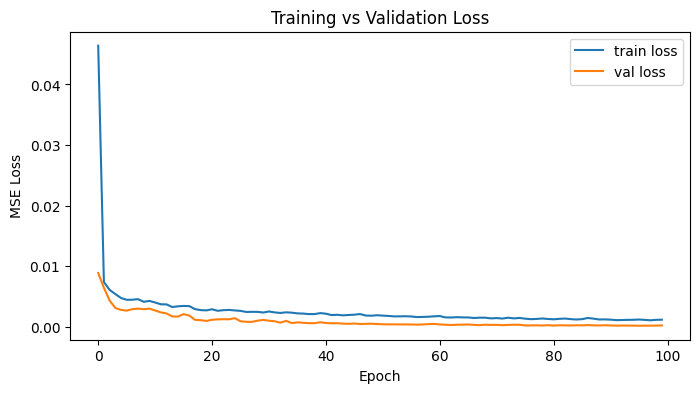

In [ ]:
# ============================
# 7) PLOT LOSS
# ============================
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


In [ ]:
# ============================
# 8) INVERSE SCALING (TARGET SAJA)
# ============================
def inverse_target_from_multiscaler(scaler, y_scaled, target_col, num_features):
    y_scaled = np.array(y_scaled).reshape(-1)
    dummy = np.zeros((len(y_scaled), num_features))
    dummy[:, target_col] = y_scaled
    return scaler.inverse_transform(dummy)[:, target_col]

num_features = len(feature_columns)

y_pred_train = model_final.predict(X_train).reshape(-1)
y_pred_test  = model_final.predict(X_test).reshape(-1)

y_train_orig = inverse_target_from_multiscaler(scaler, y_train, target_col, num_features)
y_test_orig  = inverse_target_from_multiscaler(scaler, y_test,  target_col, num_features)
y_pred_train_orig = inverse_target_from_multiscaler(scaler, y_pred_train, target_col, num_features)
y_pred_test_orig  = inverse_target_from_multiscaler(scaler, y_pred_test,  target_col, num_features)

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
# ============================
# 9) EVALUASI (SKALA ASLI)
# ============================
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))
mae  = mean_absolute_error(y_test_orig, y_pred_test_orig)


import numpy as np

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), eps, None))) * 100

mape_test = mape(y_test_orig, y_pred_test_orig)
mape_train = mape(y_train_orig, y_pred_train_orig)


print("\n=== TEST EVALUATION (ORIGINAL SCALE) ===")
print("RMSE:", rmse)
print("MAE :", mae)
print("MAPE Train (%):", mape_train)
print("MAPE Test  (%):", mape_test)



=== TEST EVALUATION (ORIGINAL SCALE) ===
RMSE: 0.08076590432206361
MAE : 0.05544383844404311
MAPE Train (%): 1.6035356110948422
MAPE Test  (%): 0.9347300266655642


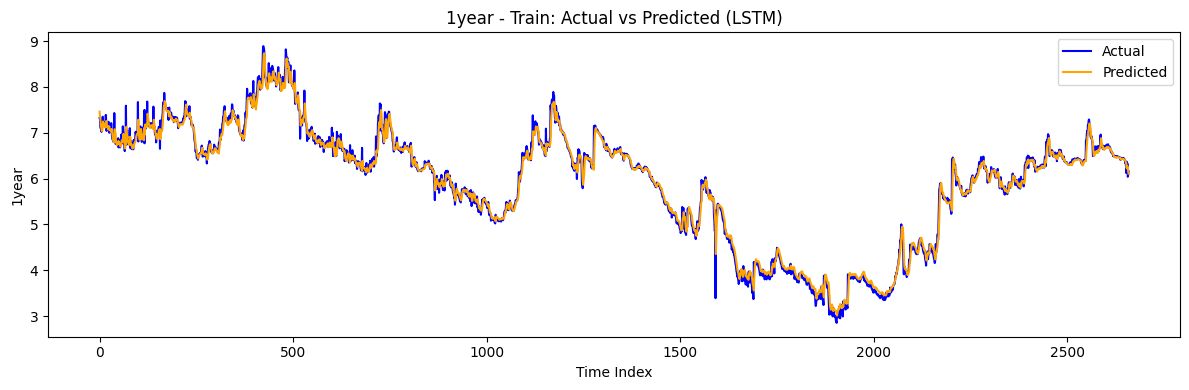

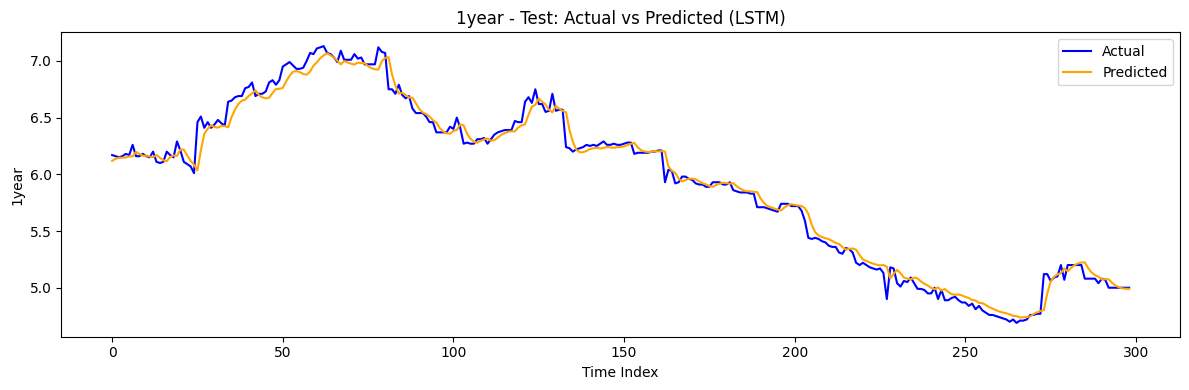

In [ ]:
import matplotlib.pyplot as plt

# ============================
# PLOT TRAIN: ACTUAL vs PRED
# ============================
plt.figure(figsize=(12,4))
plt.plot(y_train_orig, label="Actual", color="blue")
plt.plot(y_pred_train_orig, label="Predicted", color="orange")
plt.title(f"{target_name} - Train: Actual vs Predicted (LSTM)")
plt.xlabel("Time Index")
plt.ylabel(target_name)
plt.legend()
plt.tight_layout()
plt.show()


# ============================
# PLOT TEST: ACTUAL vs PRED
# ============================
plt.figure(figsize=(12,4))
plt.plot(y_test_orig, label="Actual", color="blue")
plt.plot(y_pred_test_orig, label="Predicted", color="orange")
plt.title(f"{target_name} - Test: Actual vs Predicted (LSTM)")
plt.xlabel("Time Index")
plt.ylabel(target_name)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Train dataframe
df_pred_train = pd.DataFrame({
    "actual": y_train_orig,
    "pred": y_pred_train_orig
})
df_pred_train["residual"] = df_pred_train["actual"] - df_pred_train["pred"]
df_pred_train["abs_error"] = np.abs(df_pred_train["residual"])
df_pred_train["ape_%"] = df_pred_train["abs_error"] / np.clip(np.abs(df_pred_train["actual"]), 1e-8, None) * 100

# Test dataframe
df_pred_test = pd.DataFrame({
    "actual": y_test_orig,
    "pred": y_pred_test_orig
})
df_pred_test["residual"] = df_pred_test["actual"] - df_pred_test["pred"]
df_pred_test["abs_error"] = np.abs(df_pred_test["residual"])
df_pred_test["ape_%"] = df_pred_test["abs_error"] / np.clip(np.abs(df_pred_test["actual"]), 1e-8, None) * 100

# Simpan
train_path = f"pred_actual_train_{target_name}.csv"
test_path  = f"pred_actual_test_{target_name}.csv"

df_pred_train.to_csv(train_path, index=False)
df_pred_test.to_csv(test_path, index=False)

print("✅ Saved:", train_path)
print("✅ Saved:", test_path)


✅ Saved: pred_actual_train_1year.csv
✅ Saved: pred_actual_test_1year.csv


# Uji white Noise

In [ ]:
import pandas as pd
import numpy as np

target_name = "1year"
path = f"hybrid_bilstm_xgb_{target_name}_test.csv"

df_res = pd.read_csv(path)

# pilih residual mana yang mau diuji:
# residual Bi-LSTM saja:
res_bilstm = df_res["residual_true"].values

# residual hybrid:
res_hybrid = df_res["residual_hybrid"].values

print("N residual Bi-LSTM:", len(res_bilstm))
print("N residual Hybrid :", len(res_hybrid))


N residual Bi-LSTM: 299
N residual Hybrid : 299


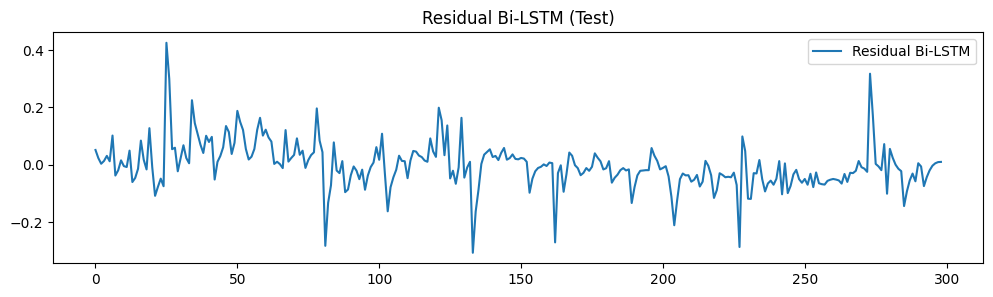

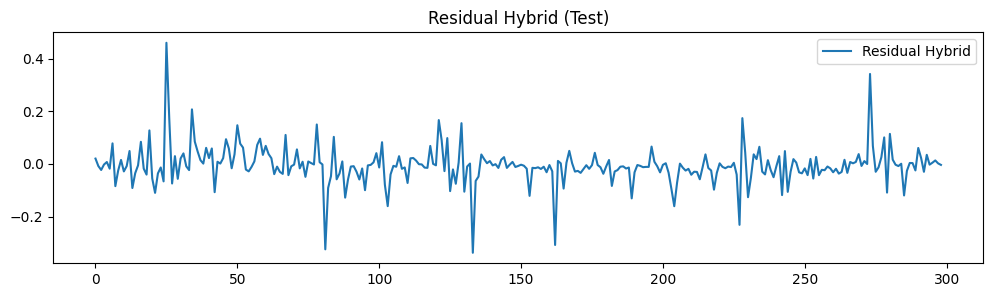

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))
plt.plot(res_bilstm, label="Residual Bi-LSTM")
plt.title("Residual Bi-LSTM (Test)")
plt.legend()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(res_hybrid, label="Residual Hybrid")
plt.title("Residual Hybrid (Test)")
plt.legend()
plt.show()


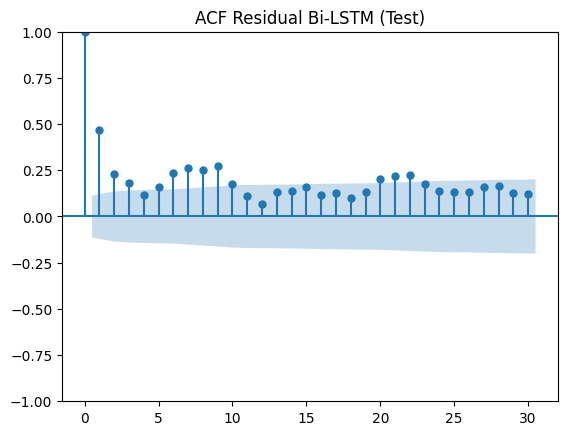

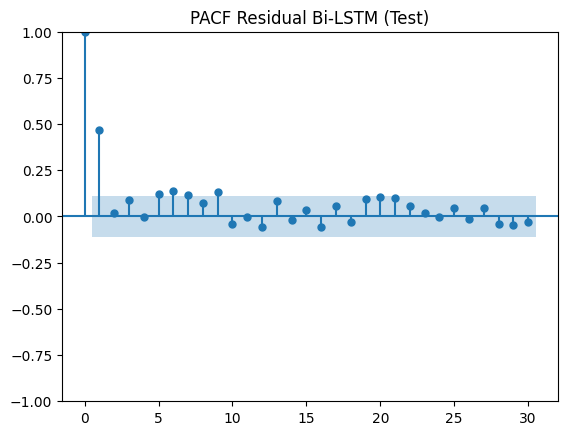

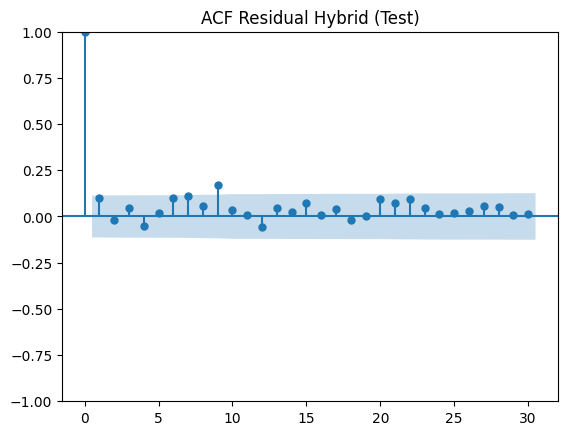

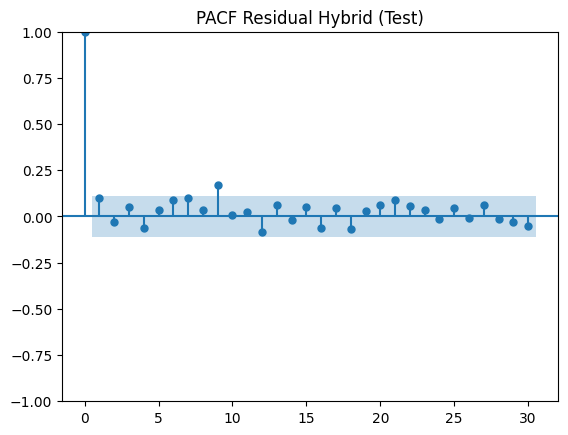

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lags = 30

plot_acf(res_bilstm, lags=lags)
plt.title("ACF Residual Bi-LSTM (Test)")
plt.show()

plot_pacf(res_bilstm, lags=lags, method="ywm")
plt.title("PACF Residual Bi-LSTM (Test)")
plt.show()

plot_acf(res_hybrid, lags=lags)
plt.title("ACF Residual Hybrid (Test)")
plt.show()

plot_pacf(res_hybrid, lags=lags, method="ywm")
plt.title("PACF Residual Hybrid (Test)")
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lags_test = [10, 20, 30]  # bisa kamu ubah

lb_bilstm = acorr_ljungbox(res_bilstm, lags=lags_test, return_df=True)
lb_hybrid = acorr_ljungbox(res_hybrid, lags=lags_test, return_df=True)

print("\nLjung-Box Bi-LSTM:")
display(lb_bilstm)

print("\nLjung-Box Hybrid:")
display(lb_hybrid)



Ljung-Box Bi-LSTM:


,lb_stat,lb_pvalue
10,193.697483,3.322092e-36
20,250.103588,1.088668e-41
30,338.068858,7.547826e-54



Ljung-Box Hybrid:


,lb_stat,lb_pvalue
10,21.896974,0.015638
20,28.710594,0.093616
30,36.393910,0.195462


# Pembentukan Model Hybrid XgBoost

In [ ]:
res_train = (y_train_orig - y_pred_train_orig)  # 1D
res_test  = (y_test_orig  - y_pred_test_orig)   # 1D


In [ ]:
def create_residual_features(residuals, main_preds, lags=12):
    """
    residuals : 1D array (aktual - prediksi Bi-LSTM) [skala asli]
    main_preds: 1D array prediksi Bi-LSTM            [skala asli]
    lags      : jumlah lag

    Output:
      X shape = (n-lags, 2*lags)
      y shape = (n-lags,)
    """
    residuals = np.asarray(residuals).reshape(-1)
    main_preds = np.asarray(main_preds).reshape(-1)

    X, y = [], []
    for i in range(lags, len(residuals)):
        feats = np.hstack([residuals[i-lags:i], main_preds[i-lags:i]])
        X.append(feats)
        y.append(residuals[i])
    return np.array(X), np.array(y)


In [ ]:
lag_resid = 1

# TRAIN XGB residual
X_res_train, y_res_train = create_residual_features(res_train, y_pred_train_orig, lags=lag_resid)

# TEST XGB residual: pakai konteks dari akhir train
res_test_with_context = np.hstack([res_train[-lag_resid:], res_test])
pred_test_with_context = np.hstack([y_pred_train_orig[-lag_resid:], y_pred_test_orig])

X_res_test, y_res_test = create_residual_features(res_test_with_context, pred_test_with_context, lags=lag_resid)

print("X_res_train:", X_res_train.shape, "y_res_train:", y_res_train.shape)
print("X_res_test :", X_res_test.shape,  "y_res_test :", y_res_test.shape)


X_res_train: (2658, 2) y_res_train: (2658,)
X_res_test : (299, 2) y_res_test : (299,)


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid_xgb = {
    "n_estimators": [200,300],
    "max_depth": [2,3],
    "learning_rate": [0.05, 0.001],
    "subsample": [0.8,0.9],
    "colsample_bytree": [0.8,0.9]
}

xgb_base = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

tscv = TimeSeriesSplit(n_splits=3)

grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("⏳ GridSearch XGBoost untuk residual berjalan...")
grid_xgb.fit(X_res_train, y_res_train)

print("\n===== BEST XGBOOST PARAMS (RESIDUAL) =====")
print("Best Params:", grid_xgb.best_params_)
print("Best CV MSE:", -grid_xgb.best_score_)

best_xgb = grid_xgb.best_estimator_


⏳ GridSearch XGBoost untuk residual berjalan...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

===== BEST XGBOOST PARAMS (RESIDUAL) =====
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.8}
Best CV MSE: 0.015835217158547958


In [ ]:
import pandas as pd

# Ambil semua hasil gridsearch
results_xgb = pd.DataFrame(grid_xgb.cv_results_)

# Ubah skor jadi MSE positif
results_xgb["mean_test_MSE"] = -results_xgb["mean_test_score"]
results_xgb["mean_train_MSE"] = -results_xgb["mean_train_score"]

# Pilih kolom penting
cols_show = [
    "mean_test_MSE",
    "std_test_score",
    "mean_train_MSE",
    "param_n_estimators",
    "param_max_depth",
    "param_learning_rate",
    "param_subsample",
    "param_colsample_bytree"
]

results_view_xgb = results_xgb[cols_show].sort_values("mean_test_MSE")

print("=== TOP 10 KOMBINASI XGBOOST (MSE TERKECIL) ===")
print(results_view_xgb.head(10))


=== TOP 10 KOMBINASI XGBOOST (MSE TERKECIL) ===
    mean_test_MSE  std_test_score  mean_train_MSE  param_n_estimators  \
0        0.015835        0.002876        0.016724                 200   
16       0.015835        0.002876        0.016724                 200   
17       0.015863        0.002885        0.016830                 200   
1        0.015863        0.002885        0.016830                 200   
2        0.016036        0.002898        0.016242                 300   
18       0.016036        0.002898        0.016242                 300   
19       0.016200        0.003014        0.016300                 300   
3        0.016200        0.003014        0.016300                 300   
5        0.016233        0.002972        0.015657                 200   
21       0.016233        0.002972        0.015657                 200   

    param_max_depth  param_learning_rate  param_subsample  \
0                 2                 0.05              0.8   
16                2       

In [ ]:
results_view_xgb.to_csv("gridsearch_xgb_residual_results.csv", index=False)
print("✅ File gridsearch_xgb_residual_results.csv berhasil disimpan")


✅ File gridsearch_xgb_residual_results.csv berhasil disimpan


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ================
# PREDIKSI RESIDUAL
# ================
res_pred_train = best_xgb.predict(X_res_train)  # shape (n_train_res,)
res_pred_test  = best_xgb.predict(X_res_test)   # shape (n_test_res,)

# =========================================================
# HYBRID PREDICTION (HARUS ALIGN DENGAN LAG)
# Karena X_res_* dimulai dari index = lag_resid,
# maka y_pred_train_orig & y_train_orig juga dipotong [lag_resid:]
# =========================================================
y_hybrid_train = y_pred_train_orig[lag_resid:] + res_pred_train
y_hybrid_test  = y_pred_test_orig + res_pred_test   # test sudah align (karena pakai context)

# actual yang sesuai
y_train_actual_aligned = y_train_orig[lag_resid:]
y_test_actual_aligned  = y_test_orig

# =================
# EVALUASI TRAIN
# =================
rmse_hybrid_train = np.sqrt(mean_squared_error(y_train_actual_aligned, y_hybrid_train))
mae_hybrid_train  = mean_absolute_error(y_train_actual_aligned, y_hybrid_train)
mape_hybrid_train = mape(y_train_actual_aligned, y_hybrid_train)

# =================
# EVALUASI TEST
# =================
rmse_hybrid_test = np.sqrt(mean_squared_error(y_test_actual_aligned, y_hybrid_test))
mae_hybrid_test  = mean_absolute_error(y_test_actual_aligned, y_hybrid_test)
mape_hybrid_test = mape(y_test_actual_aligned, y_hybrid_test)

print("\n=== HYBRID EVALUATION (TRAIN) ===")
print("RMSE Hybrid Train:", rmse_hybrid_train)
print("MAE  Hybrid Train:", mae_hybrid_train)
print("MAPE Hybrid Train (%):", mape_hybrid_train)

print("\n=== HYBRID EVALUATION (TEST) ===")
print("RMSE Hybrid Test:", rmse_hybrid_test)
print("MAE  Hybrid Test:", mae_hybrid_test)
print("MAPE Hybrid Test (%):", mape_hybrid_test)



=== HYBRID EVALUATION (TRAIN) ===
RMSE Hybrid Train: 0.1235575277424507
MAE  Hybrid Train: 0.07503376739330886
MAPE Hybrid Train (%): 1.3050376484874024

=== HYBRID EVALUATION (TEST) ===
RMSE Hybrid Test: 0.07160533430285938
MAE  Hybrid Test: 0.04294205506242131
MAPE Hybrid Test (%): 0.7220812754759762


In [ ]:
import pandas as pd

# =========================
# ALIGN DATA TRAIN
# =========================
# karena residual XGBoost pakai lag, train harus dipotong
actual_train_aligned = y_train_orig[lag_resid:]
pred_bilstm_train_aligned = y_pred_train_orig[lag_resid:]

# =========================
# DATAFRAME TRAIN
# =========================
df_hybrid_train = pd.DataFrame({
    "actual": actual_train_aligned,
    "pred_bilstm": pred_bilstm_train_aligned,
    "residual_true": actual_train_aligned - pred_bilstm_train_aligned,
    "residual_pred_xgb": res_pred_train,     # hasil predict XGB train
    "pred_hybrid": y_hybrid_train
})

df_hybrid_train["residual_hybrid"] = (
    df_hybrid_train["actual"] - df_hybrid_train["pred_hybrid"]
)

# =========================
# SAVE CSV
# =========================
out_path_train = f"hybrid_bilstm_xgb_{target_name}_train.csv"
df_hybrid_train.to_csv(out_path_train, index=False)

print("✅ Saved:", out_path_train)


✅ Saved: hybrid_bilstm_xgb_1year_train.csv


In [ ]:
import pandas as pd

df_hybrid_test = pd.DataFrame({
    "actual": y_test_orig,
    "pred_bilstm": y_pred_test_orig,
    "residual_true": y_test_orig - y_pred_test_orig,
    "residual_pred_xgb": res_pred_test,
    "pred_hybrid": y_hybrid_test
})

df_hybrid_test["residual_hybrid"] = df_hybrid_test["actual"] - df_hybrid_test["pred_hybrid"]

out_path = f"hybrid_bilstm_xgb_{target_name}_test.csv"
df_hybrid_test.to_csv(out_path, index=False)
print("✅ Saved:", out_path)


✅ Saved: hybrid_bilstm_xgb_1year_test.csv


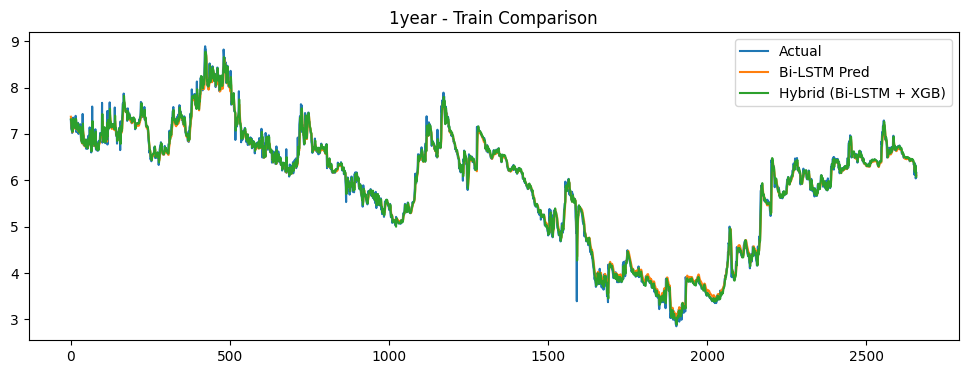

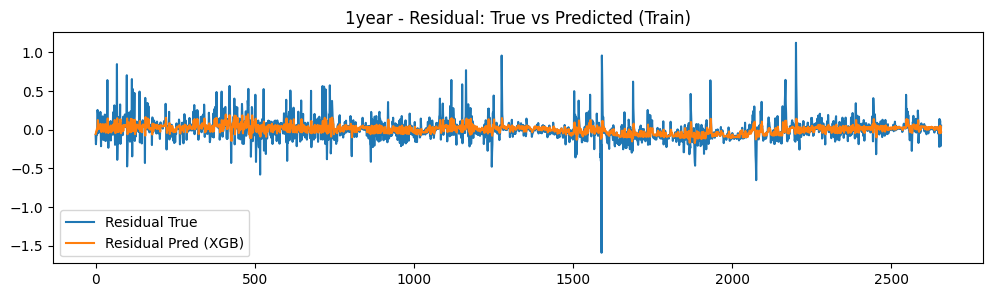

In [ ]:
import matplotlib.pyplot as plt

# =========================
# TRAIN: Actual vs Prediction
# =========================
plt.figure(figsize=(12,4))
plt.plot(df_hybrid_train["actual"], label="Actual")
plt.plot(df_hybrid_train["pred_bilstm"], label="Bi-LSTM Pred")
plt.plot(df_hybrid_train["pred_hybrid"], label="Hybrid (Bi-LSTM + XGB)")
plt.title(f"{target_name} - Train Comparison")
plt.legend()
plt.show()

# =========================
# TRAIN: Residual Comparison
# =========================
plt.figure(figsize=(12,3))
plt.plot(df_hybrid_train["residual_true"], label="Residual True")
plt.plot(df_hybrid_train["residual_pred_xgb"], label="Residual Pred (XGB)")
plt.title(f"{target_name} - Residual: True vs Predicted (Train)")
plt.legend()
plt.show()


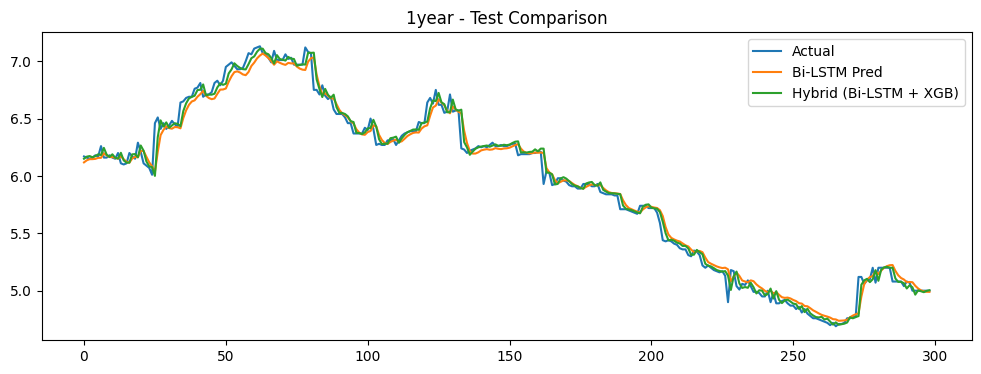

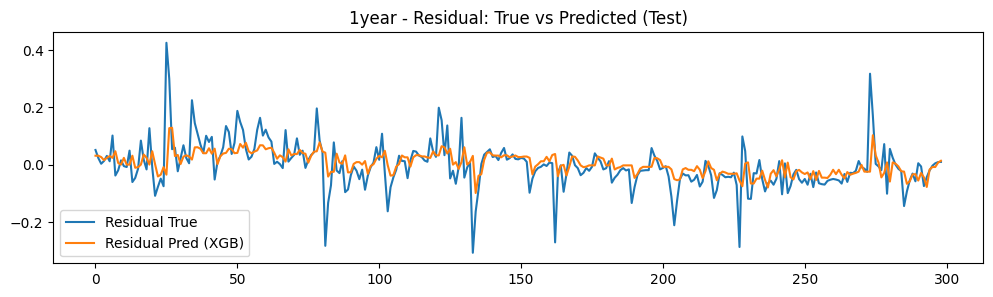

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df_hybrid_test["actual"], label="Actual")
plt.plot(df_hybrid_test["pred_bilstm"], label="Bi-LSTM Pred")
plt.plot(df_hybrid_test["pred_hybrid"], label="Hybrid (Bi-LSTM + XGB)")
plt.title(f"{target_name} - Test Comparison")
plt.legend()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(df_hybrid_test["residual_true"], label="Residual True")
plt.plot(df_hybrid_test["residual_pred_xgb"], label="Residual Pred (XGB)")
plt.title(f"{target_name} - Residual: True vs Predicted (Test)")
plt.legend()
plt.show()


In [ ]:
mape_bilstm = mape(y_test_orig, y_pred_test_orig)

print("\n=== PERBANDINGAN MAPE (TEST) ===")
print("MAPE Bi-LSTM (%):", mape_bilstm)
print("MAPE Hybrid  (%):", mape_hybrid_test)
print("Improvement (%):", mape_bilstm - mape_hybrid_test)



=== PERBANDINGAN MAPE (TEST) ===
MAPE Bi-LSTM (%): 0.9347300266655642
MAPE Hybrid  (%): 0.7220812754759762
Improvement (%): 0.21264875118958793


# Future Forecast

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# pastikan target yang sedang kamu forecast
target_name = "1year"              # ganti: "1year"/"5year"/"10year"
feature_columns = [target_name]     # univariat
target_col = 0

# ambil nilai target saja
values = df[feature_columns].values  # shape (T, 1)

# split 80:20 time-based
split_idx = int(len(values) * 0.8)
train_raw = values[:split_idx]
test_raw  = values[split_idx:]

# scaling (fit hanya di train)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_raw)
test_scaled  = scaler.transform(test_raw)

# gabungkan supaya window terakhir benar-benar ujung dataset
scaled_all = np.vstack([train_scaled, test_scaled])

SEQ_LEN = 30  # sesuaikan
last_window = scaled_all[-SEQ_LEN:]   # ✅ (SEQ_LEN, 1)


In [ ]:
import numpy as np

# ===========
# SETUP AWAL
# ===========
horizon = 30  # jumlah langkah ke depan

# last_window harus dari data scaled (misal test_scaled[-SEQ_LEN:])
# last_window shape: (SEQ_LEN, num_features)
current_window = last_window.copy()

# ambil residual & prediksi terakhir (skala asli) untuk XGB fitur
# res_test: residual test (aktual - pred LSTM) skala asli, 1D
# y_pred_test_orig: prediksi LSTM test skala asli, 1D
last_residuals  = res_test[-lag_resid:].tolist()
last_main_preds = y_pred_test_orig[-lag_resid:].tolist()

# penampung hasil future
future_preds_lstm = []
future_residual_preds = []
future_preds_hybrid = []

# ===========================
# RECURSIVE MULTI-STEP FORECAST
# ===========================
for step in range(horizon):

    # -------------------------
    # (1) Forecast nilai utama (LSTM)
    # -------------------------
    next_pred_scaled = model_final.predict(
        current_window.reshape(1, SEQ_LEN, len(feature_columns)),
        verbose=0
    )[0, 0]

    # inverse scaling ke skala asli (target saja)
    dummy = np.zeros((1, len(feature_columns)))
    dummy[0, target_col] = next_pred_scaled
    next_pred_orig = scaler.inverse_transform(dummy)[0, target_col]

    # -------------------------
    # (2) Forecast residual future (XGBoost)
    # fitur XGB = [lag residual, lag prediksi LSTM]  (sesuai modelmu sekarang)
    # -------------------------
    x_res_feat = np.array(last_residuals + last_main_preds).reshape(1, -1)
    next_residual_pred = best_xgb.predict(x_res_feat)[0]

    # -------------------------
    # (3) Hybrid = LSTM + residual_pred
    # -------------------------
    next_hybrid = next_pred_orig + next_residual_pred

    # simpan hasil step ini
    future_preds_lstm.append(next_pred_orig)
    future_residual_preds.append(next_residual_pred)
    future_preds_hybrid.append(next_hybrid)

    # -------------------------
    # (4) Update buffer untuk step berikutnya
    # -------------------------
    # update lag residual & lag pred LSTM
    last_residuals  = last_residuals[1:] + [next_residual_pred]
    last_main_preds = last_main_preds[1:] + [next_pred_orig]

    # update window input LSTM (scaled) -> masukkan prediksi scaled pada kolom target
    new_row = current_window[-1].copy()

    # kalau univariat: num_features=1, target_col = 0
    new_row[target_col] = next_pred_scaled

    current_window = np.vstack([current_window[1:], new_row])

# convert jadi numpy array
future_preds_lstm = np.array(future_preds_lstm)
future_residual_preds = np.array(future_residual_preds)
future_preds_hybrid = np.array(future_preds_hybrid)

print("Future forecast LSTM (orig):", future_preds_lstm[:5])
print("Future forecast Residual (XGB):", future_residual_preds[:5])
print("Future forecast Hybrid (orig):", future_preds_hybrid[:5])


Future forecast LSTM (orig): [4.99150308 4.99056327 4.99253758 4.99888171 5.01068723]
Future forecast Residual (XGB): [0.01407666 0.01586319 0.01586319 0.01586319 0.01586319]
Future forecast Hybrid (orig): [5.00557974 5.00642647 5.00840077 5.01474491 5.02655042]


In [ ]:
import pandas as pd

df_future = pd.DataFrame({
    "step": np.arange(1, horizon+1),
    "forecast_lstm": future_preds_lstm,
    "forecast_residual_xgb": future_residual_preds,
    "forecast_hybrid": future_preds_hybrid
})

df_future.to_csv(f"future_forecast_hybrid_{target_name}.csv", index=False)
print("✅ Saved future forecast:", f"future_forecast_hybrid_{target_name}.csv")


✅ Saved future forecast: future_forecast_hybrid_1year.csv


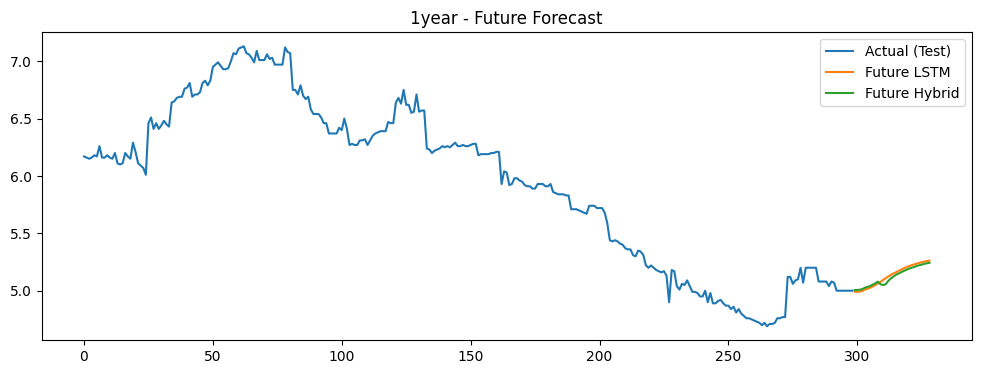

In [ ]:
plt.figure(figsize=(12,4))

plt.plot(
    np.arange(len(y_test_orig)),
    y_test_orig,
    label="Actual (Test)"
)

plt.plot(
    np.arange(len(y_test_orig), len(y_test_orig) + horizon),
    future_preds_lstm[:horizon],
    label="Future LSTM"
)

plt.plot(
    np.arange(len(y_test_orig), len(y_test_orig) + horizon),
    future_preds_hybrid,
    label="Future Hybrid"
)

plt.title(f"{target_name} - Future Forecast")
plt.legend()
plt.show()


In [ ]:
print("Last actual test :", y_test_orig[-1])
print("First future LSTM:", future_preds_lstm[0])
print("First future Hyb :", future_preds_hybrid[0])


Last actual test : 5.0
First future LSTM: 4.991503084897995
First future Hyb : 5.005579743422568


In [ ]:
rets = df[["1year","5year","10year"]].diff().dropna()  # perubahan harian
print(rets.corr())


           1year     5year    10year
1year   1.000000  0.119587  0.075631
5year   0.119587  1.000000  0.752649
10year  0.075631  0.752649  1.000000
